### Thermodynamic neural network for RNAP
This notebook contains a neural network model which is interpretable as a thermodynamic model of RNAP binding to the lac promoter.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Input, Concatenate, Lambda
from keras.optimizers import Adam,SGD
import keras.backend as K
import keras
import logomaker

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import random

Using TensorFlow backend.


## Curate simulated data

### load position weight matrices for RNAP and CRP

In [2]:
# Load the energy matrices from Kinney et al. 2010
crp_df = pd.read_csv('../data/energy_matrices/crp_tau_final_all.26.txt', sep = "\t", usecols = range(1,5))
rnap_df = pd.read_csv('../data/energy_matrices/rnap_tau_final_all.41.txt', sep = "\t", usecols = range(1,5))
rnap_df_suppl = pd.read_csv('../data/energy_matrices/rnap_tau_final_all.41_supplement.txt', sep = "\t", usecols = range(1,5))

# Convert the dataframe to numpy array for downstream processing
crp_array = pd.DataFrame.to_numpy(crp_df)
#rnap_array = pd.DataFrame.to_numpy(rnap_df)
#rnap_array_suppl = pd.DataFrame.to_numpy(rnap_df_suppl)
rnap_array = pd.DataFrame.to_numpy(rnap_df_suppl)

### set parameters

In [3]:
# Set up parameters
gaps = 7 # Length of gaps between CRP and RNAP binding sites
c_r = 5.94e-3 # Concentration of RNAP; Empirically determined
c_c = 10 ** -1.2 # Concentration of active CRP
e_i = -3.26 # Energy of interaction
t_bg = 0.01 # Background noise
consensus_sequence = "AATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG"
rnap_wt_seq = "CAGGCTTTACACCTGTTGCCTCCGGCTCGTATGTTGTGTGG"
crp_wt_energy = 6.9 # From Kinney et al. 2010
rnap_wt_energy = 8.3 # From Kinney et al. 2010

### Helper functions

In [4]:
def mutate_sequence(con_seq, mut_rate):
    bases = ["A","C","G","T"]
    new_seq = list(con_seq)
    to_mutate = np.random.random(size = len(con_seq)) < mut_rate
    for i in range(0,len(to_mutate)):
        if to_mutate[i]:
            new_seq[i] = random.choice([b for b in bases if b not in new_seq[i]])
    return ''.join(new_seq)

# Fit a label encoder and a onehot encoder
bases = ["A","C","G","T"]
label_encoder = LabelEncoder()
label_encoder.fit(bases)
tmp = label_encoder.transform(bases)
tmp = tmp.reshape(len(tmp), 1)
onehot_encoder = OneHotEncoder(sparse = False)
onehot_encoder.fit(tmp)

# Encode sequence into onehot
def onehot_sequence(sequence, lab_encoder = label_encoder, one_encoder = onehot_encoder):
    """Sequence as a string"""
    tmp = lab_encoder.transform(list(sequence))
    tmp = tmp.reshape(len(tmp),1)
    tmp = one_encoder.transform(tmp)
    return tmp

# Calculate energy
def get_energy(seq_onehot, matrix_array):
    return np.sum(matrix_array * seq_onehot)
    
# Calculate boltzmann weight
def get_transcription(e_r, e_c, e_i = -3.26, c_r = 5.94e-3, c_c = 10 ** -1.2):
    #const = 1.98e-3 * 310
    const = 1
    tmp1 = c_r*np.exp(-e_r/const) + c_c*c_r*np.exp(-(e_c+e_r+e_i)/const)
    tmp2 = 1 + c_c*np.exp(-e_c/const) + c_r*np.exp(-e_r/const) + c_c*c_r*np.exp(-(e_c+e_r+e_i)/const)
    return 5*tmp1/tmp2, tmp2

def get_rnap_transcription(energy,mu=-2.7):
    tau_max = 1.00
    return tau_max*(np.exp(-(energy-mu))/(1+np.exp(-(energy-mu))))

def reverse_complement(seq):
    complement = str.maketrans('ATCGN', 'TAGCN')
    return str(seq).upper().translate(complement)[::-1]

In [5]:
# mu_rnap = get_energy(onehot_sequence(rnap_wt_seq),rnap_array)-4.6
# wt_epsilon_rnap = get_energy(onehot_sequence(rnap_wt_seq),rnap_array)
# rnap_df_centered = logomaker.Logo(rnap_df,center_values=True).df.values
# print(get_energy(onehot_sequence(rnap_wt_seq),rnap_df_centered))
# print(wt_epsilon_rnap)
# print(mu_rnap)

In [6]:
def generate_mutant_seqs_and_their_transcription_rates(wt_seq = rnap_wt_seq, mutrate = 0.1):
    """
    helper function which generates simulated data; data consists of mutant sequences and their 
    associated transcription rates.
    """
    
    rnap_sequence = wt_seq
    next_rnap_sequence = mutate_sequence(rnap_sequence,mutrate)
    
    #er = get_energy(onehot_sequence(next_sequence[26:67]),rnap_array)
    er = get_energy(onehot_sequence(next_rnap_sequence),rnap_array)
    
    #tau, Z = get_transcription(ec,er)
    tau_rnap = get_rnap_transcription(er,mu=2.7)
    
    #return next_sequence, tau, ec, er, Z
    return next_rnap_sequence, er, tau_rnap

input_sequences = [] 
labels = []

e_c_list = []
e_r_list = []
test_e_r_list = []

test_input_sequences = []
test_labels = []
# partition function


for _ in range(10000):
    
    if _ < 9000:
        
        temp_seq, temp_er, temp_tau_rnap = generate_mutant_seqs_and_their_transcription_rates()
        #temp_seq, temp_tau = generate_mutant_seqs_and_their_transcription_rates_rc()
        input_sequences.append(temp_seq)
        e_r_list.append(temp_er)
        labels.append(temp_tau_rnap)
    
    else:        
        
        temp_seq, temp_er, temp_tau_rnap = generate_mutant_seqs_and_their_transcription_rates()
        #temp_seq, temp_tau = generate_mutant_seqs_and_their_transcription_rates_rc()
        test_input_sequences.append(temp_seq)
        test_e_r_list.append(temp_er)
        test_labels.append(temp_tau_rnap)

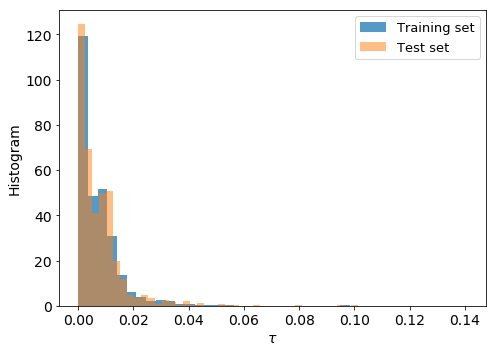

In [7]:
plt.figure(figsize=(7,5))
plt.hist(labels,bins=40,alpha=0.75,density=True,label='Training set')
plt.hist(test_labels,bins=40,alpha=0.5,density=True,label='Test set')
plt.legend(fontsize=13)
plt.xlabel(r'$\tau$',fontsize=14)
plt.ylabel('Histogram',fontsize=14)
plt.tick_params(labelsize=14)
plt.tight_layout()
#plt.savefig('../write_up/write_up_for_rnap_neural_network/tau_hist.png')
plt.show()

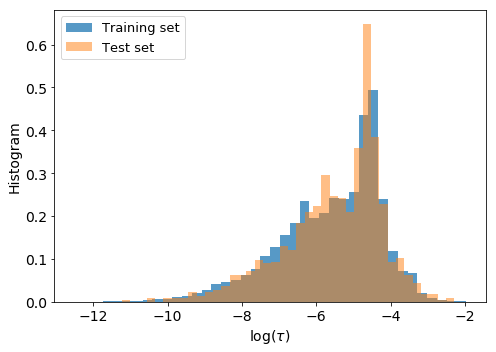

In [8]:
plt.figure(figsize=(7,5))
plt.hist(np.log(labels),bins=40,alpha=0.75,density=True,label='Training set')
plt.hist(np.log(test_labels),bins=40,alpha=0.5,density=True,label='Test set')
plt.legend(fontsize=13)
plt.xlabel('log('+r'$\tau$)',fontsize=14)
plt.ylabel('Histogram',fontsize=14)
plt.tick_params(labelsize=14)
plt.tight_layout()
#plt.savefig('../write_up/write_up_for_rnap_neural_network/log_tau_hist.png')
plt.show()

In [9]:
# labels = -np.log(labels)
# test_labels = -np.log(test_labels)

## Code for custom layer

In [10]:
import tensorflow as tf
from keras.layers import multiply

class CustomConnected(Dense):

    def __init__(self,units,connections, output_dim,**kwargs):
        
        self.output_dim = output_dim
        #this is matrix of connections. I.e., this should be [0,0,trainable,trainable]
        self.connections = connections                        
        #initalize the original Dense with all the usual arguments   
        super(CustomConnected,self).__init__(units,**kwargs)  


    def call(self, inputs):
        #print(self.connections)
        
        kernel_times_connections = multiply([self.kernel, self.connections])
        #output = K.dot(inputs, self.kernel * self.connections)
        output = K.dot(inputs,kernel_times_connections)

        #print('outputs: ',output)
        #print('inputs: ',inputs)
        #print('kernel',self.kernel)
        
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    
        

## Neural Network Model (1 Protein)

In [11]:
number_input_layer_nodes = len(test_input_sequences[0])*4    
inputTensor = Input((number_input_layer_nodes,),name='Sequence')

In [12]:
energy_layer = Dense(1,activation='linear',use_bias=True,name='energy_layer')(inputTensor)
softmaxLayer = Dense(2,activation='softmax', trainable=False, use_bias=False,name='softmax_layer')(energy_layer)
outputTensor = CustomConnected(1,tf.constant([0.0,1.0]),1,use_bias=False,name='custom_tao_layer')(softmaxLayer)

#create the model:
model = Model(inputTensor,outputTensor)

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Sequence (InputLayer)        (None, 164)               0         
_________________________________________________________________
energy_layer (Dense)         (None, 1)                 165       
_________________________________________________________________
softmax_layer (Dense)        (None, 2)                 2         
_________________________________________________________________
custom_tao_layer (CustomConn (None, 1)                 2         
Total params: 169
Trainable params: 167
Non-trainable params: 2
_________________________________________________________________


#### Naive one-hot encoding

In [14]:
# the following loop separates a string into individuals characters
# e.g 'AAAA' -> ['A', 'A', 'A', 'A']

temp_input_sequences = []

for reshape_index in range(len(input_sequences)):
    temp_input_sequences.append(list(np.array(input_sequences)[reshape_index]))
    
input_sequences = temp_input_sequences
input_sequences = np.array(input_sequences)

labels = np.array(labels)
labels = np.array(labels).reshape(labels.shape[0],1)


temp_test_input_sequences = []

for reshape_test_index in range(len(test_input_sequences)):
    temp_test_input_sequences.append(list(np.array(test_input_sequences)[reshape_test_index]))
    
test_input_sequences = temp_test_input_sequences
test_input_sequences = np.array(test_input_sequences)

test_labels = np.array(test_labels)
test_labels = np.array(test_labels).reshape(test_labels.shape[0],1)


In [15]:
# check shape
input_sequences.shape

(9000, 41)

In [16]:
# see one training sequences
input_sequences[0]

array(['C', 'A', 'G', 'G', 'C', 'T', 'T', 'T', 'A', 'C', 'A', 'C', 'T',
       'T', 'G', 'T', 'T', 'G', 'C', 'C', 'T', 'C', 'C', 'G', 'G', 'C',
       'C', 'C', 'G', 'T', 'A', 'T', 'G', 'T', 'T', 'A', 'T', 'G', 'T',
       'A', 'G'], dtype='<U1')

In [17]:
# define dictionary for one-hot encoding
base_dict = {"A":0,"C":1,"G":2,"T":3}
input_sequences_tensor = np.zeros(list(input_sequences.shape) + [4])    # the number 4 here represents the amounts of states in base_dict,
test_input_sequences_tensor = np.zeros(list(test_input_sequences.shape) + [4])

In [18]:
num_sample = len(input_sequences_tensor)
seq_length = len(input_sequences[0])

#naive one-hot encoding
for row in range(num_sample):
    for col in range(seq_length):
        input_sequences_tensor[row,col,base_dict[input_sequences[row,col]]] = 1

        

num_test_sample = len(test_input_sequences_tensor)
test_seq_length = len(test_input_sequences[0])        
        
#naive one-hot encoding for test sequences
for test_row in range(num_test_sample):
    for test_col in range(test_seq_length):
        test_input_sequences_tensor[test_row,test_col,base_dict[test_input_sequences[test_row,test_col]]] = 1        


In [19]:
print('Training set shape: {}'.format(input_sequences_tensor.shape))
print('Training set label shape: {}'.format(labels.shape))

Training set shape: (9000, 41, 4)
Training set label shape: (9000, 1)


reshape input tensor so shape goes from (num_samples, seq_length, characters) -> (num_samples,seq_length*character). This can be fed into the first layer.

In [20]:
input_sequences_tensor = input_sequences_tensor.reshape(-1,164)
test_input_sequences_tensor = test_input_sequences_tensor.reshape(-1,164)

In [21]:
model.layers

In [22]:
# see weights before training. These stay frozen if I set trainable=False in softmax layer.
model.layers[2].get_weights()

[array([[-0.50496274,  0.71244514]], dtype=float32)]

### Set layer weights manually
Note that the bias weights here may be interpreted as gamma

In [23]:
# # the following two work
softmax_weights = np.array([[0,1]])


# # keras' set_weights expects weights and bias in a list
#softmax_weights = [softmax_weights,softmax_biases]

# # without bias
softmax_weights = [softmax_weights]

# # set weights
model.layers[2].set_weights(softmax_weights)
# # see set weights
model.layers[2].get_weights()

[array([[0., 1.]], dtype=float32)]

### Set last layer weights

In [24]:
last_layer_initial_weights = np.array([0,1]).reshape(2,1)
model.layers[3].set_weights([last_layer_initial_weights])
model.layers[3].get_weights()[0]

array([[0.],
       [1.]], dtype=float32)

### Compile Model

In [25]:
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.00005), metrics=['mean_absolute_error'])
#model.compile(loss='mean_squared_error',optimizer=sgd, metrics=['mean_absolute_error'])

### Fit Neural Network

In [26]:
history = model.fit(input_sequences_tensor, labels, validation_split=0.1, epochs=2000,verbose=1)  # starts training

Train on 8100 samples, validate on 900 samples
Epoch 1/2000
8100/8100 [==============================] - 0s 40us/step - loss: 0.0512 - mean_absolute_error: 0.2173 - val_loss: 0.0358 - val_mean_absolute_error: 0.1823
Epoch 2/2000
8100/8100 [==============================] - 0s 21us/step - loss: 0.0267 - mean_absolute_error: 0.1558 - val_loss: 0.0201 - val_mean_absolute_error: 0.1356
Epoch 3/2000
8100/8100 [==============================] - 0s 21us/step - loss: 0.0157 - mean_absolute_error: 0.1188 - val_loss: 0.0125 - val_mean_absolute_error: 0.1063
Epoch 4/2000
8100/8100 [==============================] - 0s 25us/step - loss: 0.0101 - mean_absolute_error: 0.0948 - val_loss: 0.0084 - val_mean_absolute_error: 0.0865
Epoch 5/2000
8100/8100 [==============================] - 0s 25us/step - loss: 0.0070 - mean_absolute_error: 0.0782 - val_loss: 0.0059 - val_mean_absolute_error: 0.0724
Epoch 6/2000
8100/8100 [==============================] - 0s 26us/step - loss: 0.0050 - mean_absolute_error:

8100/8100 [==============================] - 0s 21us/step - loss: 3.7437e-05 - mean_absolute_error: 0.0041 - val_loss: 2.9717e-05 - val_mean_absolute_error: 0.0039
Epoch 94/2000
8100/8100 [==============================] - 0s 21us/step - loss: 3.6634e-05 - mean_absolute_error: 0.0040 - val_loss: 2.9026e-05 - val_mean_absolute_error: 0.0039
Epoch 95/2000
8100/8100 [==============================] - 0s 21us/step - loss: 3.5870e-05 - mean_absolute_error: 0.0040 - val_loss: 2.8426e-05 - val_mean_absolute_error: 0.0038
Epoch 96/2000
8100/8100 [==============================] - 0s 20us/step - loss: 3.5067e-05 - mean_absolute_error: 0.0039 - val_loss: 2.7881e-05 - val_mean_absolute_error: 0.0038
Epoch 97/2000
8100/8100 [==============================] - 0s 21us/step - loss: 3.4308e-05 - mean_absolute_error: 0.0039 - val_loss: 2.7263e-05 - val_mean_absolute_error: 0.0038
Epoch 98/2000
8100/8100 [==============================] - 0s 20us/step - loss: 3.3543e-05 - mean_absolute_error: 0.0039 - v

Epoch 139/2000
8100/8100 [==============================] - 0s 34us/step - loss: 1.2425e-05 - mean_absolute_error: 0.0024 - val_loss: 1.0845e-05 - val_mean_absolute_error: 0.0023
Epoch 140/2000
8100/8100 [==============================] - 0s 34us/step - loss: 1.2118e-05 - mean_absolute_error: 0.0023 - val_loss: 1.0650e-05 - val_mean_absolute_error: 0.0023
Epoch 141/2000
8100/8100 [==============================] - 0s 24us/step - loss: 1.1745e-05 - mean_absolute_error: 0.0023 - val_loss: 1.0679e-05 - val_mean_absolute_error: 0.0024
Epoch 142/2000
8100/8100 [==============================] - 0s 23us/step - loss: 1.1473e-05 - mean_absolute_error: 0.0023 - val_loss: 1.0165e-05 - val_mean_absolute_error: 0.0023
Epoch 143/2000
8100/8100 [==============================] - 0s 22us/step - loss: 1.1155e-05 - mean_absolute_error: 0.0023 - val_loss: 9.8928e-06 - val_mean_absolute_error: 0.0022
Epoch 144/2000
8100/8100 [==============================] - 0s 22us/step - loss: 1.0850e-05 - mean_absolu

Epoch 185/2000
8100/8100 [==============================] - 0s 23us/step - loss: 3.3082e-06 - mean_absolute_error: 0.0012 - val_loss: 3.4083e-06 - val_mean_absolute_error: 0.0012
Epoch 186/2000
8100/8100 [==============================] - 0s 28us/step - loss: 3.2059e-06 - mean_absolute_error: 0.0012 - val_loss: 3.3247e-06 - val_mean_absolute_error: 0.0012
Epoch 187/2000
8100/8100 [==============================] - 0s 28us/step - loss: 3.1080e-06 - mean_absolute_error: 0.0012 - val_loss: 3.2195e-06 - val_mean_absolute_error: 0.0012
Epoch 188/2000
8100/8100 [==============================] - 0s 27us/step - loss: 3.0197e-06 - mean_absolute_error: 0.0011 - val_loss: 3.1409e-06 - val_mean_absolute_error: 0.0012
Epoch 189/2000
8100/8100 [==============================] - 0s 29us/step - loss: 2.9247e-06 - mean_absolute_error: 0.0011 - val_loss: 3.0489e-06 - val_mean_absolute_error: 0.0011
Epoch 190/2000
8100/8100 [==============================] - 0s 24us/step - loss: 2.8342e-06 - mean_absolu

8100/8100 [==============================] - 0s 21us/step - loss: 3.1234e-07 - mean_absolute_error: 2.7234e-04 - val_loss: 3.1342e-07 - val_mean_absolute_error: 2.7737e-04
Epoch 273/2000
8100/8100 [==============================] - 0s 20us/step - loss: 3.0365e-07 - mean_absolute_error: 2.6678e-04 - val_loss: 3.0467e-07 - val_mean_absolute_error: 2.7561e-04
Epoch 274/2000
8100/8100 [==============================] - 0s 21us/step - loss: 2.9583e-07 - mean_absolute_error: 2.6162e-04 - val_loss: 2.9680e-07 - val_mean_absolute_error: 2.8029e-04
Epoch 275/2000
8100/8100 [==============================] - 0s 21us/step - loss: 2.8738e-07 - mean_absolute_error: 2.5742e-04 - val_loss: 2.8852e-07 - val_mean_absolute_error: 2.6058e-04
Epoch 276/2000
8100/8100 [==============================] - 0s 21us/step - loss: 2.8014e-07 - mean_absolute_error: 2.5347e-04 - val_loss: 2.8163e-07 - val_mean_absolute_error: 2.5356e-04
Epoch 277/2000
8100/8100 [==============================] - 0s 23us/step - loss:

Epoch 316/2000
8100/8100 [==============================] - 0s 22us/step - loss: 8.9431e-08 - mean_absolute_error: 1.2760e-04 - val_loss: 8.9546e-08 - val_mean_absolute_error: 1.3681e-04
Epoch 317/2000
8100/8100 [==============================] - 0s 21us/step - loss: 8.6704e-08 - mean_absolute_error: 1.2466e-04 - val_loss: 8.7138e-08 - val_mean_absolute_error: 1.2704e-04
Epoch 318/2000
8100/8100 [==============================] - 0s 22us/step - loss: 8.4008e-08 - mean_absolute_error: 1.2215e-04 - val_loss: 8.4255e-08 - val_mean_absolute_error: 1.2806e-04
Epoch 319/2000
8100/8100 [==============================] - 0s 22us/step - loss: 8.1360e-08 - mean_absolute_error: 1.2021e-04 - val_loss: 8.2263e-08 - val_mean_absolute_error: 1.3652e-04
Epoch 320/2000
8100/8100 [==============================] - 0s 22us/step - loss: 7.9187e-08 - mean_absolute_error: 1.1912e-04 - val_loss: 7.9327e-08 - val_mean_absolute_error: 1.2681e-04
Epoch 321/2000
8100/8100 [==============================] - 0s 22

Epoch 360/2000
8100/8100 [==============================] - 0s 20us/step - loss: 2.2932e-08 - mean_absolute_error: 5.5812e-05 - val_loss: 2.4247e-08 - val_mean_absolute_error: 6.3363e-05
Epoch 361/2000
8100/8100 [==============================] - 0s 20us/step - loss: 2.2258e-08 - mean_absolute_error: 5.5487e-05 - val_loss: 2.2843e-08 - val_mean_absolute_error: 5.6047e-05
Epoch 362/2000
8100/8100 [==============================] - 0s 20us/step - loss: 2.1604e-08 - mean_absolute_error: 5.4259e-05 - val_loss: 2.2135e-08 - val_mean_absolute_error: 6.2614e-05
Epoch 363/2000
8100/8100 [==============================] - 0s 20us/step - loss: 2.0985e-08 - mean_absolute_error: 5.3826e-05 - val_loss: 2.1451e-08 - val_mean_absolute_error: 5.9281e-05
Epoch 364/2000
8100/8100 [==============================] - 0s 20us/step - loss: 2.0272e-08 - mean_absolute_error: 5.1368e-05 - val_loss: 2.0866e-08 - val_mean_absolute_error: 5.3067e-05
Epoch 365/2000
8100/8100 [==============================] - 0s 20

Epoch 404/2000
8100/8100 [==============================] - 0s 20us/step - loss: 6.4545e-09 - mean_absolute_error: 2.9831e-05 - val_loss: 6.6564e-09 - val_mean_absolute_error: 2.9897e-05
Epoch 405/2000
8100/8100 [==============================] - 0s 20us/step - loss: 6.2159e-09 - mean_absolute_error: 2.7902e-05 - val_loss: 6.3719e-09 - val_mean_absolute_error: 2.9567e-05
Epoch 406/2000
8100/8100 [==============================] - 0s 20us/step - loss: 6.0189e-09 - mean_absolute_error: 2.7238e-05 - val_loss: 6.1967e-09 - val_mean_absolute_error: 2.8388e-05
Epoch 407/2000
8100/8100 [==============================] - 0s 21us/step - loss: 5.8232e-09 - mean_absolute_error: 2.6438e-05 - val_loss: 6.0435e-09 - val_mean_absolute_error: 2.7487e-05
Epoch 408/2000
8100/8100 [==============================] - 0s 20us/step - loss: 5.6615e-09 - mean_absolute_error: 2.5863e-05 - val_loss: 6.0609e-09 - val_mean_absolute_error: 3.4495e-05
Epoch 409/2000
8100/8100 [==============================] - 0s 20

Epoch 448/2000
8100/8100 [==============================] - 0s 26us/step - loss: 2.1361e-09 - mean_absolute_error: 1.6822e-05 - val_loss: 2.2996e-09 - val_mean_absolute_error: 1.9128e-05
Epoch 449/2000
8100/8100 [==============================] - 0s 27us/step - loss: 2.1168e-09 - mean_absolute_error: 1.7018e-05 - val_loss: 2.1515e-09 - val_mean_absolute_error: 1.7103e-05
Epoch 450/2000
8100/8100 [==============================] - 0s 25us/step - loss: 2.0907e-09 - mean_absolute_error: 1.7331e-05 - val_loss: 2.8769e-09 - val_mean_absolute_error: 3.1862e-05
Epoch 451/2000
8100/8100 [==============================] - 0s 27us/step - loss: 2.0985e-09 - mean_absolute_error: 1.7907e-05 - val_loss: 2.1154e-09 - val_mean_absolute_error: 1.9029e-05
Epoch 452/2000
8100/8100 [==============================] - 0s 31us/step - loss: 1.9944e-09 - mean_absolute_error: 1.6628e-05 - val_loss: 1.9798e-09 - val_mean_absolute_error: 1.6048e-05
Epoch 453/2000
8100/8100 [==============================] - 0s 26

Epoch 492/2000
8100/8100 [==============================] - 0s 22us/step - loss: 8.7570e-10 - mean_absolute_error: 1.2237e-05 - val_loss: 9.2383e-10 - val_mean_absolute_error: 1.5085e-05
Epoch 493/2000
8100/8100 [==============================] - 0s 25us/step - loss: 8.5019e-10 - mean_absolute_error: 1.1876e-05 - val_loss: 8.2930e-10 - val_mean_absolute_error: 1.3363e-05
Epoch 494/2000
8100/8100 [==============================] - 0s 27us/step - loss: 8.1732e-10 - mean_absolute_error: 1.1279e-05 - val_loss: 8.6480e-10 - val_mean_absolute_error: 1.4221e-05
Epoch 495/2000
8100/8100 [==============================] - 0s 23us/step - loss: 7.9789e-10 - mean_absolute_error: 1.1369e-05 - val_loss: 7.8356e-10 - val_mean_absolute_error: 1.1066e-05
Epoch 496/2000
8100/8100 [==============================] - 0s 23us/step - loss: 7.7042e-10 - mean_absolute_error: 1.0972e-05 - val_loss: 7.8302e-10 - val_mean_absolute_error: 1.2016e-05
Epoch 497/2000
8100/8100 [==============================] - 0s 24

Epoch 536/2000
8100/8100 [==============================] - 0s 22us/step - loss: 4.2541e-10 - mean_absolute_error: 9.0807e-06 - val_loss: 5.8015e-10 - val_mean_absolute_error: 1.3666e-05
Epoch 537/2000
8100/8100 [==============================] - 0s 22us/step - loss: 4.3794e-10 - mean_absolute_error: 9.7544e-06 - val_loss: 3.6325e-10 - val_mean_absolute_error: 9.5788e-06
Epoch 538/2000
8100/8100 [==============================] - 0s 22us/step - loss: 3.9025e-10 - mean_absolute_error: 8.9835e-06 - val_loss: 7.6504e-10 - val_mean_absolute_error: 1.9102e-05
Epoch 539/2000
8100/8100 [==============================] - 0s 22us/step - loss: 3.7996e-10 - mean_absolute_error: 9.1729e-06 - val_loss: 3.5161e-10 - val_mean_absolute_error: 8.0947e-06
Epoch 540/2000
8100/8100 [==============================] - 0s 23us/step - loss: 3.5697e-10 - mean_absolute_error: 8.4857e-06 - val_loss: 3.4281e-10 - val_mean_absolute_error: 8.2483e-06
Epoch 541/2000
8100/8100 [==============================] - 0s 21

Epoch 580/2000
8100/8100 [==============================] - 0s 23us/step - loss: 2.2915e-10 - mean_absolute_error: 7.6415e-06 - val_loss: 4.2066e-10 - val_mean_absolute_error: 1.1754e-05
Epoch 581/2000
8100/8100 [==============================] - 0s 22us/step - loss: 1.8394e-10 - mean_absolute_error: 7.1771e-06 - val_loss: 1.7052e-10 - val_mean_absolute_error: 6.3441e-06
Epoch 582/2000
8100/8100 [==============================] - 0s 22us/step - loss: 1.8400e-10 - mean_absolute_error: 6.7204e-06 - val_loss: 2.4638e-10 - val_mean_absolute_error: 8.1063e-06
Epoch 583/2000
8100/8100 [==============================] - 0s 22us/step - loss: 2.3803e-10 - mean_absolute_error: 7.8765e-06 - val_loss: 1.5079e-10 - val_mean_absolute_error: 6.3796e-06
Epoch 584/2000
8100/8100 [==============================] - 0s 23us/step - loss: 2.2513e-10 - mean_absolute_error: 7.6685e-06 - val_loss: 1.5946e-10 - val_mean_absolute_error: 6.7838e-06
Epoch 585/2000
8100/8100 [==============================] - 0s 24

Epoch 624/2000
8100/8100 [==============================] - 0s 21us/step - loss: 1.4335e-10 - mean_absolute_error: 6.1780e-06 - val_loss: 1.0740e-10 - val_mean_absolute_error: 5.5514e-06
Epoch 625/2000
8100/8100 [==============================] - 0s 22us/step - loss: 1.3646e-10 - mean_absolute_error: 6.4023e-06 - val_loss: 1.1139e-10 - val_mean_absolute_error: 6.3558e-06
Epoch 626/2000
8100/8100 [==============================] - 0s 22us/step - loss: 1.3265e-10 - mean_absolute_error: 6.4049e-06 - val_loss: 1.2937e-10 - val_mean_absolute_error: 7.5546e-06
Epoch 627/2000
8100/8100 [==============================] - 0s 21us/step - loss: 1.3744e-10 - mean_absolute_error: 6.4257e-06 - val_loss: 1.0231e-10 - val_mean_absolute_error: 5.8702e-06
Epoch 628/2000
8100/8100 [==============================] - 0s 20us/step - loss: 1.0688e-10 - mean_absolute_error: 5.6936e-06 - val_loss: 1.0621e-10 - val_mean_absolute_error: 5.9375e-06
Epoch 629/2000
8100/8100 [==============================] - 0s 21

Epoch 668/2000
8100/8100 [==============================] - 0s 22us/step - loss: 1.3839e-10 - mean_absolute_error: 6.3021e-06 - val_loss: 1.1339e-10 - val_mean_absolute_error: 5.2593e-06
Epoch 669/2000
8100/8100 [==============================] - 0s 22us/step - loss: 9.4584e-11 - mean_absolute_error: 5.6015e-06 - val_loss: 6.8226e-11 - val_mean_absolute_error: 4.3700e-06
Epoch 670/2000
8100/8100 [==============================] - 0s 22us/step - loss: 1.2453e-10 - mean_absolute_error: 6.0708e-06 - val_loss: 9.8742e-11 - val_mean_absolute_error: 5.1225e-06
Epoch 671/2000
8100/8100 [==============================] - 0s 21us/step - loss: 1.2047e-10 - mean_absolute_error: 5.8638e-06 - val_loss: 9.3417e-11 - val_mean_absolute_error: 5.9570e-06
Epoch 672/2000
8100/8100 [==============================] - 0s 21us/step - loss: 9.3285e-11 - mean_absolute_error: 5.5281e-06 - val_loss: 1.1483e-10 - val_mean_absolute_error: 6.4137e-06
Epoch 673/2000
8100/8100 [==============================] - 0s 20

Epoch 712/2000
8100/8100 [==============================] - 0s 21us/step - loss: 7.7205e-11 - mean_absolute_error: 4.8869e-06 - val_loss: 4.4800e-11 - val_mean_absolute_error: 3.9587e-06
Epoch 713/2000
8100/8100 [==============================] - 0s 21us/step - loss: 9.7493e-11 - mean_absolute_error: 5.2400e-06 - val_loss: 7.0591e-11 - val_mean_absolute_error: 4.8098e-06
Epoch 714/2000
8100/8100 [==============================] - 0s 21us/step - loss: 6.8817e-11 - mean_absolute_error: 4.8755e-06 - val_loss: 8.2606e-11 - val_mean_absolute_error: 5.9962e-06
Epoch 715/2000
8100/8100 [==============================] - 0s 22us/step - loss: 9.0877e-11 - mean_absolute_error: 5.3571e-06 - val_loss: 6.0094e-11 - val_mean_absolute_error: 4.7219e-06
Epoch 716/2000
8100/8100 [==============================] - 0s 22us/step - loss: 5.9926e-11 - mean_absolute_error: 4.5188e-06 - val_loss: 4.7065e-11 - val_mean_absolute_error: 4.0143e-06
Epoch 717/2000
8100/8100 [==============================] - 0s 20

Epoch 756/2000
8100/8100 [==============================] - 0s 20us/step - loss: 6.3126e-11 - mean_absolute_error: 4.4973e-06 - val_loss: 4.9164e-11 - val_mean_absolute_error: 4.3563e-06
Epoch 757/2000
8100/8100 [==============================] - 0s 21us/step - loss: 9.4137e-11 - mean_absolute_error: 5.3558e-06 - val_loss: 1.0174e-10 - val_mean_absolute_error: 6.6397e-06
Epoch 758/2000
8100/8100 [==============================] - 0s 21us/step - loss: 7.6078e-11 - mean_absolute_error: 4.8658e-06 - val_loss: 4.0984e-11 - val_mean_absolute_error: 3.1139e-06
Epoch 759/2000
8100/8100 [==============================] - 0s 21us/step - loss: 1.0134e-10 - mean_absolute_error: 5.2960e-06 - val_loss: 5.8189e-11 - val_mean_absolute_error: 5.1550e-06
Epoch 760/2000
8100/8100 [==============================] - 0s 21us/step - loss: 5.7846e-11 - mean_absolute_error: 4.5546e-06 - val_loss: 4.3831e-11 - val_mean_absolute_error: 4.3603e-06
Epoch 761/2000
8100/8100 [==============================] - 0s 21

Epoch 800/2000
8100/8100 [==============================] - 0s 21us/step - loss: 6.9644e-11 - mean_absolute_error: 4.4685e-06 - val_loss: 4.4779e-11 - val_mean_absolute_error: 3.3917e-06
Epoch 801/2000
8100/8100 [==============================] - 0s 20us/step - loss: 5.3393e-11 - mean_absolute_error: 4.1060e-06 - val_loss: 2.8457e-11 - val_mean_absolute_error: 2.8709e-06
Epoch 802/2000
8100/8100 [==============================] - 0s 21us/step - loss: 7.1503e-11 - mean_absolute_error: 4.5489e-06 - val_loss: 3.2765e-11 - val_mean_absolute_error: 4.0619e-06
Epoch 803/2000
8100/8100 [==============================] - 0s 22us/step - loss: 7.3209e-11 - mean_absolute_error: 4.6034e-06 - val_loss: 5.6359e-11 - val_mean_absolute_error: 3.1968e-06
Epoch 804/2000
8100/8100 [==============================] - 0s 23us/step - loss: 5.3250e-11 - mean_absolute_error: 3.9023e-06 - val_loss: 3.9992e-10 - val_mean_absolute_error: 1.1953e-05
Epoch 805/2000
8100/8100 [==============================] - 0s 22

Epoch 844/2000
8100/8100 [==============================] - 0s 21us/step - loss: 7.4627e-11 - mean_absolute_error: 4.2992e-06 - val_loss: 2.9688e-11 - val_mean_absolute_error: 3.1464e-06
Epoch 845/2000
8100/8100 [==============================] - 0s 21us/step - loss: 9.3888e-11 - mean_absolute_error: 4.8079e-06 - val_loss: 5.4933e-11 - val_mean_absolute_error: 4.4860e-06
Epoch 846/2000
8100/8100 [==============================] - 0s 22us/step - loss: 4.5233e-11 - mean_absolute_error: 3.9285e-06 - val_loss: 4.3524e-11 - val_mean_absolute_error: 4.2425e-06
Epoch 847/2000
8100/8100 [==============================] - 0s 22us/step - loss: 4.9947e-11 - mean_absolute_error: 3.9665e-06 - val_loss: 3.6377e-11 - val_mean_absolute_error: 3.7330e-06
Epoch 848/2000
8100/8100 [==============================] - 0s 22us/step - loss: 8.0614e-11 - mean_absolute_error: 4.5073e-06 - val_loss: 6.2032e-11 - val_mean_absolute_error: 5.1919e-06
Epoch 849/2000
8100/8100 [==============================] - 0s 20

Epoch 888/2000
8100/8100 [==============================] - 0s 22us/step - loss: 5.8070e-11 - mean_absolute_error: 4.0976e-06 - val_loss: 3.5682e-11 - val_mean_absolute_error: 2.8957e-06
Epoch 889/2000
8100/8100 [==============================] - 0s 22us/step - loss: 5.6721e-11 - mean_absolute_error: 4.0064e-06 - val_loss: 3.5767e-11 - val_mean_absolute_error: 4.1914e-06
Epoch 890/2000
8100/8100 [==============================] - 0s 22us/step - loss: 6.9309e-11 - mean_absolute_error: 4.1981e-06 - val_loss: 3.0980e-11 - val_mean_absolute_error: 3.0410e-06
Epoch 891/2000
8100/8100 [==============================] - 0s 22us/step - loss: 5.6603e-11 - mean_absolute_error: 4.0685e-06 - val_loss: 4.3987e-11 - val_mean_absolute_error: 4.3158e-06
Epoch 892/2000
8100/8100 [==============================] - 0s 21us/step - loss: 7.0196e-11 - mean_absolute_error: 4.3216e-06 - val_loss: 3.5911e-11 - val_mean_absolute_error: 4.3327e-06
Epoch 893/2000
8100/8100 [==============================] - 0s 21

Epoch 932/2000
8100/8100 [==============================] - 0s 21us/step - loss: 4.1526e-11 - mean_absolute_error: 3.5067e-06 - val_loss: 3.3485e-11 - val_mean_absolute_error: 3.4968e-06
Epoch 933/2000
8100/8100 [==============================] - 0s 21us/step - loss: 2.9215e-11 - mean_absolute_error: 3.0245e-06 - val_loss: 6.9859e-11 - val_mean_absolute_error: 4.3261e-06
Epoch 934/2000
8100/8100 [==============================] - 0s 21us/step - loss: 5.6216e-11 - mean_absolute_error: 3.9558e-06 - val_loss: 3.0908e-11 - val_mean_absolute_error: 3.6920e-06
Epoch 935/2000
8100/8100 [==============================] - 0s 21us/step - loss: 7.8504e-11 - mean_absolute_error: 4.4765e-06 - val_loss: 3.2564e-11 - val_mean_absolute_error: 3.7579e-06
Epoch 936/2000
8100/8100 [==============================] - 0s 21us/step - loss: 4.0235e-11 - mean_absolute_error: 3.3262e-06 - val_loss: 5.6896e-11 - val_mean_absolute_error: 4.7852e-06
Epoch 937/2000
8100/8100 [==============================] - 0s 21

Epoch 976/2000
8100/8100 [==============================] - 0s 21us/step - loss: 4.3877e-11 - mean_absolute_error: 3.3226e-06 - val_loss: 2.7131e-11 - val_mean_absolute_error: 2.6068e-06
Epoch 977/2000
8100/8100 [==============================] - 0s 20us/step - loss: 3.6221e-11 - mean_absolute_error: 3.3314e-06 - val_loss: 4.3567e-11 - val_mean_absolute_error: 4.0043e-06
Epoch 978/2000
8100/8100 [==============================] - 0s 21us/step - loss: 5.3543e-11 - mean_absolute_error: 3.8050e-06 - val_loss: 2.0395e-11 - val_mean_absolute_error: 2.8815e-06
Epoch 979/2000
8100/8100 [==============================] - 0s 22us/step - loss: 3.5439e-11 - mean_absolute_error: 3.3142e-06 - val_loss: 2.5105e-11 - val_mean_absolute_error: 2.6926e-06
Epoch 980/2000
8100/8100 [==============================] - 0s 22us/step - loss: 5.4133e-11 - mean_absolute_error: 3.7456e-06 - val_loss: 3.8176e-11 - val_mean_absolute_error: 3.9350e-06
Epoch 981/2000
8100/8100 [==============================] - 0s 23

Epoch 1020/2000
8100/8100 [==============================] - 0s 20us/step - loss: 6.0050e-11 - mean_absolute_error: 3.9809e-06 - val_loss: 8.4382e-11 - val_mean_absolute_error: 6.5338e-06
Epoch 1021/2000
8100/8100 [==============================] - 0s 20us/step - loss: 3.8787e-11 - mean_absolute_error: 3.4646e-06 - val_loss: 2.2862e-11 - val_mean_absolute_error: 2.1923e-06
Epoch 1022/2000
8100/8100 [==============================] - 0s 20us/step - loss: 3.3298e-11 - mean_absolute_error: 3.1486e-06 - val_loss: 2.6022e-11 - val_mean_absolute_error: 2.2774e-06
Epoch 1023/2000
8100/8100 [==============================] - 0s 21us/step - loss: 7.1087e-11 - mean_absolute_error: 3.9740e-06 - val_loss: 4.7372e-11 - val_mean_absolute_error: 3.3078e-06
Epoch 1024/2000
8100/8100 [==============================] - 0s 20us/step - loss: 3.5794e-11 - mean_absolute_error: 3.2927e-06 - val_loss: 7.0047e-11 - val_mean_absolute_error: 5.9038e-06
Epoch 1025/2000
8100/8100 [==============================] -

Epoch 1107/2000
8100/8100 [==============================] - 0s 23us/step - loss: 7.0181e-11 - mean_absolute_error: 3.9904e-06 - val_loss: 3.7268e-11 - val_mean_absolute_error: 3.4873e-06
Epoch 1108/2000
8100/8100 [==============================] - 0s 22us/step - loss: 3.7041e-11 - mean_absolute_error: 3.2538e-06 - val_loss: 1.7791e-11 - val_mean_absolute_error: 2.5646e-06
Epoch 1109/2000
8100/8100 [==============================] - 0s 22us/step - loss: 4.6657e-11 - mean_absolute_error: 3.0792e-06 - val_loss: 2.8775e-11 - val_mean_absolute_error: 2.5347e-06
Epoch 1110/2000
8100/8100 [==============================] - 0s 22us/step - loss: 4.6496e-11 - mean_absolute_error: 3.5925e-06 - val_loss: 1.3132e-11 - val_mean_absolute_error: 1.8475e-06
Epoch 1111/2000
8100/8100 [==============================] - 0s 21us/step - loss: 2.5552e-11 - mean_absolute_error: 2.7950e-06 - val_loss: 1.7862e-11 - val_mean_absolute_error: 1.9253e-06
Epoch 1112/2000
8100/8100 [==============================] -

Epoch 1194/2000
8100/8100 [==============================] - 0s 25us/step - loss: 2.4950e-11 - mean_absolute_error: 2.7941e-06 - val_loss: 9.7898e-12 - val_mean_absolute_error: 1.9007e-06
Epoch 1195/2000
8100/8100 [==============================] - 0s 23us/step - loss: 3.5008e-11 - mean_absolute_error: 3.0927e-06 - val_loss: 1.6037e-11 - val_mean_absolute_error: 2.5065e-06
Epoch 1196/2000
8100/8100 [==============================] - 0s 21us/step - loss: 1.7276e-11 - mean_absolute_error: 2.3189e-06 - val_loss: 2.2103e-11 - val_mean_absolute_error: 2.2711e-06
Epoch 1197/2000
8100/8100 [==============================] - 0s 25us/step - loss: 1.9709e-11 - mean_absolute_error: 2.3578e-06 - val_loss: 1.2259e-11 - val_mean_absolute_error: 1.9236e-06
Epoch 1198/2000
8100/8100 [==============================] - 0s 31us/step - loss: 1.3261e-11 - mean_absolute_error: 2.0444e-06 - val_loss: 7.8334e-12 - val_mean_absolute_error: 1.4544e-06
Epoch 1199/2000
8100/8100 [==============================] -

Epoch 1281/2000
8100/8100 [==============================] - 0s 48us/step - loss: 3.0930e-11 - mean_absolute_error: 2.9317e-06 - val_loss: 7.0580e-11 - val_mean_absolute_error: 5.8426e-06
Epoch 1282/2000
8100/8100 [==============================] - 0s 48us/step - loss: 1.6250e-11 - mean_absolute_error: 2.1613e-06 - val_loss: 5.6247e-12 - val_mean_absolute_error: 1.1462e-06
Epoch 1283/2000
8100/8100 [==============================] - 0s 59us/step - loss: 4.3050e-11 - mean_absolute_error: 3.2472e-06 - val_loss: 2.0308e-11 - val_mean_absolute_error: 2.7209e-06
Epoch 1284/2000
8100/8100 [==============================] - 0s 42us/step - loss: 1.6847e-11 - mean_absolute_error: 2.1509e-06 - val_loss: 1.4891e-11 - val_mean_absolute_error: 1.7512e-06
Epoch 1285/2000
8100/8100 [==============================] - 0s 25us/step - loss: 2.1041e-11 - mean_absolute_error: 2.4640e-06 - val_loss: 8.6381e-12 - val_mean_absolute_error: 1.9454e-06
Epoch 1286/2000
8100/8100 [==============================] -

Epoch 1368/2000
8100/8100 [==============================] - 0s 21us/step - loss: 1.1837e-11 - mean_absolute_error: 1.9191e-06 - val_loss: 4.7890e-12 - val_mean_absolute_error: 1.2042e-06
Epoch 1369/2000
8100/8100 [==============================] - 0s 21us/step - loss: 2.8022e-11 - mean_absolute_error: 2.5813e-06 - val_loss: 2.4421e-11 - val_mean_absolute_error: 2.3016e-06
Epoch 1370/2000
8100/8100 [==============================] - 0s 20us/step - loss: 2.5702e-11 - mean_absolute_error: 2.4422e-06 - val_loss: 4.8801e-12 - val_mean_absolute_error: 1.4069e-06
Epoch 1371/2000
8100/8100 [==============================] - 0s 20us/step - loss: 5.8383e-11 - mean_absolute_error: 3.5901e-06 - val_loss: 1.6653e-11 - val_mean_absolute_error: 1.9592e-06
Epoch 1372/2000
8100/8100 [==============================] - 0s 20us/step - loss: 4.4254e-11 - mean_absolute_error: 3.0279e-06 - val_loss: 3.7126e-12 - val_mean_absolute_error: 1.1377e-06
Epoch 1373/2000
8100/8100 [==============================] -

Epoch 1455/2000
8100/8100 [==============================] - 0s 21us/step - loss: 1.2657e-11 - mean_absolute_error: 1.8377e-06 - val_loss: 5.6952e-12 - val_mean_absolute_error: 1.3995e-06
Epoch 1456/2000
8100/8100 [==============================] - 0s 20us/step - loss: 7.5596e-12 - mean_absolute_error: 1.5572e-06 - val_loss: 3.6942e-12 - val_mean_absolute_error: 8.2775e-07
Epoch 1457/2000
8100/8100 [==============================] - 0s 20us/step - loss: 4.9377e-11 - mean_absolute_error: 2.9450e-06 - val_loss: 2.9932e-11 - val_mean_absolute_error: 3.3583e-06
Epoch 1458/2000
8100/8100 [==============================] - 0s 21us/step - loss: 1.1963e-11 - mean_absolute_error: 1.8590e-06 - val_loss: 2.9380e-12 - val_mean_absolute_error: 9.3545e-07
Epoch 1459/2000
8100/8100 [==============================] - 0s 20us/step - loss: 7.5992e-12 - mean_absolute_error: 1.4832e-06 - val_loss: 3.7693e-12 - val_mean_absolute_error: 9.6595e-07
Epoch 1460/2000
8100/8100 [==============================] -

Epoch 1542/2000
8100/8100 [==============================] - 0s 20us/step - loss: 1.1240e-11 - mean_absolute_error: 1.7352e-06 - val_loss: 7.3095e-12 - val_mean_absolute_error: 1.2611e-06
Epoch 1543/2000
8100/8100 [==============================] - 0s 21us/step - loss: 7.6531e-12 - mean_absolute_error: 1.4904e-06 - val_loss: 1.0771e-11 - val_mean_absolute_error: 2.1359e-06
Epoch 1544/2000
8100/8100 [==============================] - 0s 23us/step - loss: 6.0686e-12 - mean_absolute_error: 1.3464e-06 - val_loss: 1.0311e-11 - val_mean_absolute_error: 2.3473e-06
Epoch 1545/2000
8100/8100 [==============================] - 0s 22us/step - loss: 6.9524e-12 - mean_absolute_error: 1.4132e-06 - val_loss: 3.4427e-12 - val_mean_absolute_error: 1.0419e-06
Epoch 1546/2000
8100/8100 [==============================] - 0s 21us/step - loss: 1.7442e-11 - mean_absolute_error: 1.9906e-06 - val_loss: 1.2844e-10 - val_mean_absolute_error: 6.9927e-06
Epoch 1547/2000
8100/8100 [==============================] -

Epoch 1629/2000
8100/8100 [==============================] - 0s 21us/step - loss: 6.3273e-12 - mean_absolute_error: 1.2499e-06 - val_loss: 2.2277e-11 - val_mean_absolute_error: 2.7912e-06
Epoch 1630/2000
8100/8100 [==============================] - 0s 20us/step - loss: 5.5648e-12 - mean_absolute_error: 1.2534e-06 - val_loss: 2.0525e-12 - val_mean_absolute_error: 7.2291e-07
Epoch 1631/2000
8100/8100 [==============================] - 0s 21us/step - loss: 1.1996e-11 - mean_absolute_error: 1.7297e-06 - val_loss: 6.9200e-12 - val_mean_absolute_error: 1.5913e-06
Epoch 1632/2000
8100/8100 [==============================] - 0s 20us/step - loss: 6.0495e-12 - mean_absolute_error: 1.2536e-06 - val_loss: 2.8706e-12 - val_mean_absolute_error: 7.2852e-07
Epoch 1633/2000
8100/8100 [==============================] - 0s 40us/step - loss: 5.6711e-12 - mean_absolute_error: 1.2036e-06 - val_loss: 2.6354e-12 - val_mean_absolute_error: 7.7690e-07
Epoch 1634/2000
8100/8100 [==============================] -

Epoch 1716/2000
8100/8100 [==============================] - 0s 20us/step - loss: 3.7142e-12 - mean_absolute_error: 1.0187e-06 - val_loss: 1.1793e-12 - val_mean_absolute_error: 5.7008e-07
Epoch 1717/2000
8100/8100 [==============================] - 0s 21us/step - loss: 3.0475e-12 - mean_absolute_error: 9.0081e-07 - val_loss: 1.5684e-12 - val_mean_absolute_error: 6.0284e-07
Epoch 1718/2000
8100/8100 [==============================] - 0s 24us/step - loss: 3.4526e-12 - mean_absolute_error: 9.9066e-07 - val_loss: 4.9930e-12 - val_mean_absolute_error: 1.1223e-06
Epoch 1719/2000
8100/8100 [==============================] - 0s 23us/step - loss: 8.3410e-12 - mean_absolute_error: 1.4981e-06 - val_loss: 3.8101e-12 - val_mean_absolute_error: 8.8519e-07
Epoch 1720/2000
8100/8100 [==============================] - 0s 20us/step - loss: 5.5354e-12 - mean_absolute_error: 1.2652e-06 - val_loss: 1.2207e-12 - val_mean_absolute_error: 6.8554e-07
Epoch 1721/2000
8100/8100 [==============================] -

Epoch 1803/2000
8100/8100 [==============================] - 0s 31us/step - loss: 4.2879e-12 - mean_absolute_error: 9.5825e-07 - val_loss: 9.3455e-12 - val_mean_absolute_error: 2.0808e-06
Epoch 1804/2000
8100/8100 [==============================] - 0s 22us/step - loss: 2.0573e-12 - mean_absolute_error: 7.8106e-07 - val_loss: 4.7993e-12 - val_mean_absolute_error: 1.2442e-06
Epoch 1805/2000
8100/8100 [==============================] - 0s 21us/step - loss: 3.0206e-12 - mean_absolute_error: 9.0203e-07 - val_loss: 1.4539e-12 - val_mean_absolute_error: 8.0780e-07
Epoch 1806/2000
8100/8100 [==============================] - 0s 20us/step - loss: 2.1928e-12 - mean_absolute_error: 7.8998e-07 - val_loss: 3.0918e-12 - val_mean_absolute_error: 1.1913e-06
Epoch 1807/2000
8100/8100 [==============================] - 0s 22us/step - loss: 1.8176e-12 - mean_absolute_error: 7.4260e-07 - val_loss: 9.3374e-13 - val_mean_absolute_error: 5.2767e-07
Epoch 1808/2000
8100/8100 [==============================] -

Epoch 1890/2000
8100/8100 [==============================] - 0s 21us/step - loss: 1.6560e-12 - mean_absolute_error: 6.5835e-07 - val_loss: 5.9241e-13 - val_mean_absolute_error: 4.2277e-07
Epoch 1891/2000
8100/8100 [==============================] - 0s 21us/step - loss: 2.3964e-12 - mean_absolute_error: 7.8725e-07 - val_loss: 1.4902e-12 - val_mean_absolute_error: 6.7725e-07
Epoch 1892/2000
8100/8100 [==============================] - 0s 21us/step - loss: 5.7622e-12 - mean_absolute_error: 9.4975e-07 - val_loss: 4.7610e-12 - val_mean_absolute_error: 9.4116e-07
Epoch 1893/2000
8100/8100 [==============================] - 0s 21us/step - loss: 9.4051e-12 - mean_absolute_error: 1.5851e-06 - val_loss: 2.5785e-12 - val_mean_absolute_error: 1.0675e-06
Epoch 1894/2000
8100/8100 [==============================] - 0s 21us/step - loss: 3.1054e-12 - mean_absolute_error: 9.1661e-07 - val_loss: 3.2101e-12 - val_mean_absolute_error: 8.9889e-07
Epoch 1895/2000
8100/8100 [==============================] -

Epoch 1977/2000
8100/8100 [==============================] - 0s 22us/step - loss: 1.8751e-12 - mean_absolute_error: 6.5453e-07 - val_loss: 7.1209e-13 - val_mean_absolute_error: 5.1721e-07
Epoch 1978/2000
8100/8100 [==============================] - 0s 24us/step - loss: 1.5955e-12 - mean_absolute_error: 6.1351e-07 - val_loss: 1.3465e-11 - val_mean_absolute_error: 2.2976e-06
Epoch 1979/2000
8100/8100 [==============================] - 0s 21us/step - loss: 1.2863e-12 - mean_absolute_error: 5.6241e-07 - val_loss: 3.5899e-11 - val_mean_absolute_error: 3.9291e-06
Epoch 1980/2000
8100/8100 [==============================] - 0s 21us/step - loss: 5.4602e-12 - mean_absolute_error: 1.1747e-06 - val_loss: 1.0635e-11 - val_mean_absolute_error: 2.2800e-06
Epoch 1981/2000
8100/8100 [==============================] - 0s 23us/step - loss: 7.1844e-12 - mean_absolute_error: 1.2757e-06 - val_loss: 5.3608e-13 - val_mean_absolute_error: 3.6952e-07
Epoch 1982/2000
8100/8100 [==============================] -

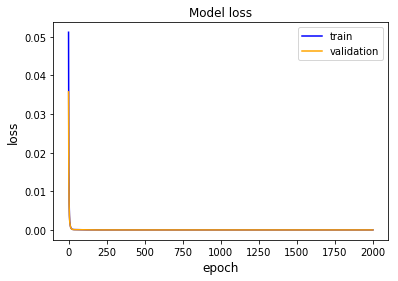

In [27]:
# plot losses

plt.figure()
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='orange')
plt.title('Model loss',fontsize=12)
plt.ylabel('loss',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['train', 'validation'])
#plt.savefig('Write_up/model_loss.png')
plt.show()

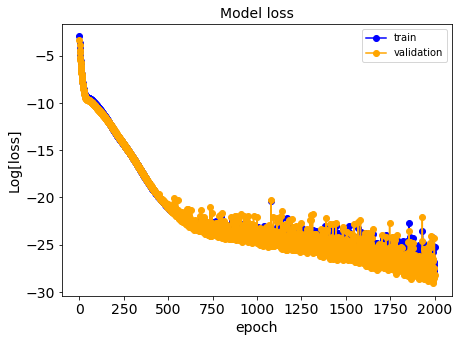

In [28]:

plt.figure(figsize=(7,5))
plt.plot(np.log(history.history['loss']),'o-',color='blue')
plt.plot(np.log(history.history['val_loss']),'o-',color='orange')
plt.title('Model loss',fontsize=14)
plt.ylabel('Log[loss]',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['train', 'validation'])
plt.tick_params(labelsize=14)
#plt.savefig('model_log_loss.pdf')
plt.show()

### Use model to make predictions on individual sequences

In [29]:
predictions_on_test = model.predict(test_input_sequences_tensor)

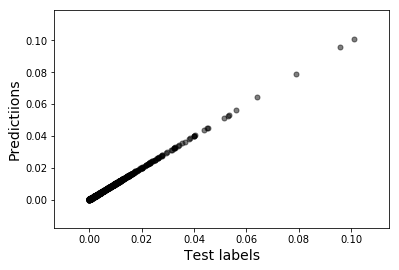

In [30]:
plt.scatter(test_labels,predictions_on_test,s=25,color="black",alpha=0.5)
plt.xlabel('Test labels',fontsize=14)
plt.ylabel('Predictiions',fontsize=14)
plt.show()
#plt.plot([0,1])

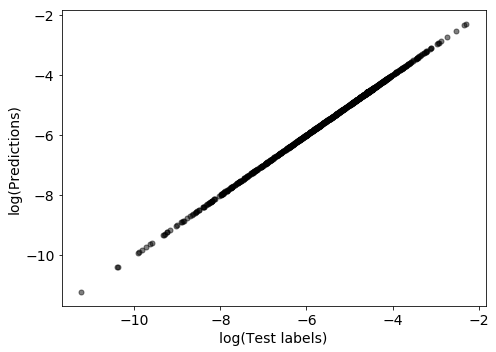

In [62]:
plt.figure(figsize=(7,5))
plt.scatter(np.log(test_labels),np.log(predictions_on_test),s=25,color="black",alpha=0.5)
plt.xlabel('log(Test labels)',fontsize=14)
plt.ylabel('log(Predictions)',fontsize=14)
plt.tick_params(labelsize=14)
plt.tight_layout()
#plt.savefig('../write_up/write_up_for_rnap_neural_network/log_predictions_vs_log_labels.png')
plt.show()
#plt.plot([0,1])

In [57]:
#np.savetxt('test_labels.txt',test_labels)
np.savetxt('predictions_on_test.txt',predictions_on_test)

In [31]:
test_labels_scaled = (test_labels-min(test_labels))/(max(test_labels)-min(test_labels))
predictions_on_test_scaled = (predictions_on_test-min(predictions_on_test))/(max(predictions_on_test)-min(predictions_on_test))

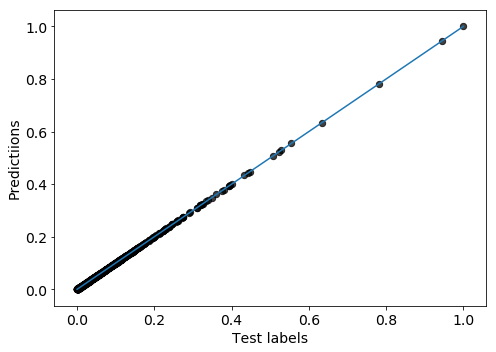

In [32]:
plt.figure(figsize=(7,5))
plt.scatter(test_labels_scaled,predictions_on_test_scaled,s=40,color="black",alpha=0.75)
plt.xlabel('Test labels',fontsize=14)
plt.ylabel('Predictions',fontsize=14)
plt.plot([0,1])
plt.tick_params(labelsize=14)
plt.tight_layout()
#plt.savefig('../write_up/write_up_for_rnap_neural_network/predictions_vs_labels.png')

plt.show()

## Get intemediate layer activations

### Softmax activation

In [33]:
# # layer 6 here corresponds to the softmax layer

# softmax_layer_model = Model(inputs=model.input,outputs=model.layers[6].output)
# softmax_output = softmax_layer_model.predict(test_input_sequences_tensor)

# plt.figure(figsize=(7,5))
# plt.hist(softmax_output[:,0:1],bins=40,alpha=0.75,label='State 1')
# plt.hist(softmax_output[:,1:2],bins=40,alpha=0.75,label='State 2')
# plt.hist(softmax_output[:,2:3],bins=40,alpha=0.75,label='State 3')
# plt.hist(softmax_output[:,3:4],bins=40,alpha=0.75,label='State 4')
# plt.legend()
# plt.title("Distributions of softmax layer activations")
# plt.show()

### First hidden layer activation (PWMs)

Need to input sequence corresponding to CRPs binding site. i.e. fixed the shape of test_input_sequences_tensor

In [34]:
# crp_layer_model = Model(inputs=model.input,outputs=model.layers[3].output)
# # need to input sequence corresponding to CRPs binding site
# test_input_sequences_tensor[0].shape
# #crp_output = crp_layer_model.predict(test_input_sequences_tensor)

# # rnap_layer_model = Model(inputs=model.input,outputs=model.layers[4].output)
# # rnap_output = rnap_layer_model.predict(test_input_sequences_tensor)

# # print(crp_output.shape)
# # print(rnap_output.shape)

In [35]:
model.layers

In [36]:
weights = model.layers[1].get_weights()[0].copy()

## Get weights of first layer and compare to PWMs

These parameters will have to be gauge fixed

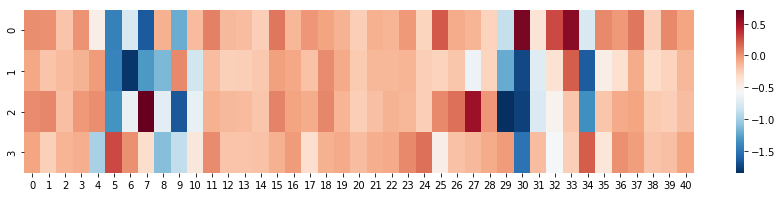

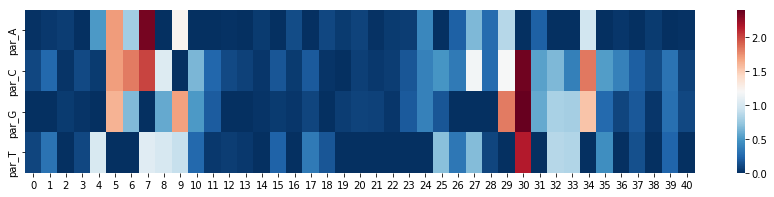

In [37]:
weights = weights.reshape(41,4)


plt.figure(figsize=(15,3))
sns.heatmap(weights.T,cmap='RdBu_r')
plt.show()
plt.figure(figsize=(15,3))
sns.heatmap(rnap_df.T,cmap='RdBu_r')
plt.show()

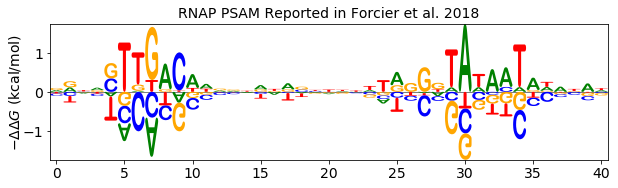

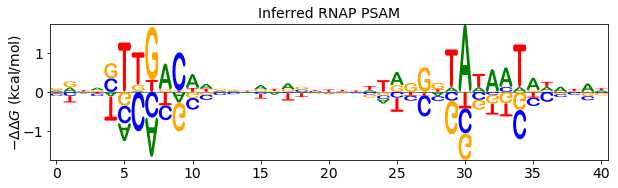

In [38]:
import logomaker
logo_df = pd.DataFrame(weights,columns=['A','C','G','T'])

rnap_df.columns = ['A','C','G','T']

logomaker.Logo(-rnap_df_suppl,center_values=True, font_name='Arial Rounded MT Bold')
plt.title('RNAP PSAM Reported in Forcier et al. 2018',fontsize=14)
plt.ylabel("$-\Delta \Delta G$ (kcal/mol)", labelpad=-1,fontsize=14)
plt.tick_params(labelsize=14)
plt.show()

learned_rnap_logo = logomaker.Logo(logo_df,center_values=True, font_name='Arial Rounded MT Bold')
plt.title('Inferred RNAP PSAM',fontsize=14)
plt.ylabel("$-\Delta \Delta G$ (kcal/mol)", labelpad=-1,fontsize=14)
plt.tick_params(labelsize=14)
plt.show()

learned_rnap_df_centered = learned_rnap_logo.df.copy()

#logomaker.Logo(rnap_logo_df,center_values=True, font_name='Arial Rounded MT Bold')

In [39]:
model.layers[2].get_weights()

[array([[0., 1.]], dtype=float32)]

In [40]:
model.layers[3].get_weights()

[array([[0.        ],
        [0.99699736]], dtype=float32)]

In [41]:
get_energy(onehot_sequence(rnap_wt_seq),rnap_array)


7.2746

In [42]:
## Save model
# np.savetxt('input_sequences_rnap.txt',input_sequences,fmt="%s",delimiter="")
# np.savetxt('input_test_sequences_rnap.txt',test_input_sequences,fmt="%s",delimiter="")
# np.savetxt('labels.txt',labels)
# np.savetxt('test_labels.txt',test_labels)
# model.save_weights('rnap_model_only_weights.h5')

In [43]:
# learned_logo = logomaker.Logo(logo_df,center_values=True, font_name='Arial Rounded MT Bold')
# get_energy(onehot_sequence(consensus_sequence[32:73]),learned_logo.df.values)

## Inferred Tau_max:

In [44]:
model.layers[3].get_weights()[0][1][0]

0.99699736

## Inferred energies epsilon_r

In [45]:
rnap_node_model = Model(inputs=model.input,outputs=model.layers[1].output)
rnap_node_activation = rnap_node_model.predict([test_input_sequences_tensor])

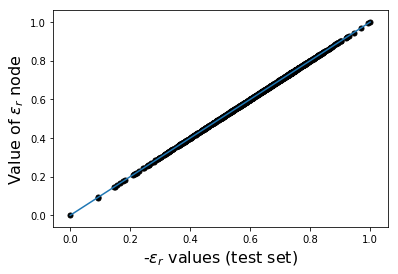

In [46]:
rnap_node_activation_scaled = (rnap_node_activation-min(rnap_node_activation))/(max(rnap_node_activation)-min(rnap_node_activation))
test_e_r_list_scaled = (test_e_r_list-min(test_e_r_list))/(max(test_e_r_list)-min(test_e_r_list))
plt.scatter(np.array(-test_e_r_list_scaled)+1,rnap_node_activation_scaled,color='black',s=25)
plt.plot([0,1])
plt.ylabel('Value of '+r'$\epsilon_r$'+' node',fontsize=16)
plt.xlabel(r'-$\epsilon_r$'+' values (test set)',fontsize=16)
plt.show()

## Inferred mu

In [47]:
#tau = test_labels.copy()
#rnap_node_activation
tau_inferred = predictions_on_test.copy()
epsilon_r_inferred = -rnap_node_activation.copy()
tau_max_inferred = model.layers[3].get_weights()[0][1][0].copy()

print('the difference between the epsilon_r ' +\
      'used to compute tau and the learned value of the epsilon_rnap_node is mu: ')
# e.g.
# for _ in range(10):
#     print(test_e_r_list[_]-abs(rnap_node_activation[_][0]))

print('mean(input_epsilon)-mean(epsilon_rnap_node)',np.mean(test_e_r_list)-abs(np.mean(rnap_node_activation)))

the difference between the epsilon_r used to compute tau and the learned value of the epsilon_rnap_node is mu: 
mean(input_epsilon)-mean(epsilon_rnap_node) 2.702971539111328


In [48]:
np.mean(epsilon_r_inferred-np.log((tau_max_inferred/tau_inferred)-1))

-2.384186e-10

In [49]:
np.mean(test_e_r_list-np.log(1/test_labels-1))

2.700000000000001

###  how do I get test_e_r_list by using test_labels?
because then I can get mu without using test_e_r_list

In [50]:
# tau_inferred is equal to test_labels (tau)
# tau = tau_max/(1+exp(epsilon_r - mu))
# (1+exp(epsilon_r - mu)) = tau_max/tau
# exp(epsilon_r - mu) = tau_max/tau-1
# epsilon_r - mu = log(tau_max/tau-1)
# mu = epsilon_r - log(tau_max/tau-1)

inferred_epsilon_from_centered_rnap_weights = []
#np.sum(onehot_sequence(test_input_sequences)*learned_rnap_df_centered.values)-np.log((1/tau_inferred)-1)
for _ in range(len(test_input_sequences)):
    inferred_epsilon_from_centered_rnap_weights.append(np.sum(onehot_sequence(test_input_sequences[_])*learned_rnap_df_centered.values))

In [51]:
temp_list = []
for _ in range(len(test_input_sequences)):
    temp_list.append(get_energy(onehot_sequence(test_input_sequences[_]),learned_rnap_df_centered.values)-abs(get_energy(onehot_sequence(test_input_sequences[_]),weights)))
    
    

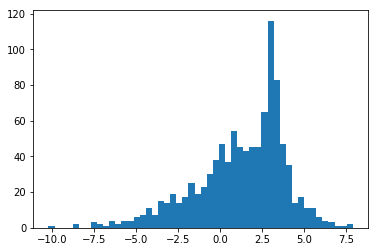

In [52]:
plt.hist(temp_list,bins=50)
plt.show()

## Softmax layer

In [53]:
# softmax_layer_model = Model(inputs=model.input,outputs=model.layers[2].output)
# softmax_output = softmax_layer_model.predict([test_input_sequences_tensor])

# # S2/S1 = exp(-(epsilon_r - mu))
# # log(S2/S1) = -epsilon+mu

# plt.figure(figsize=(7,5))
# plt.hist(softmax_output[:,1:2]/softmax_output[:,0:1],bins=40,alpha=0.5,label='S_2/S1',density=True)
# plt.hist(test_labels,bins=40,alpha=0.5,density=True,label='Test labels')
# plt.legend()
# plt.tick_params(labelsize=14)
# plt.show()

In [54]:
model.layers[1].get_weights()[1]

array([-0.14429751], dtype=float32)